In [1]:
import pandas as pd

In [2]:
import geopandas as gpd

In [618]:
df = pd.read_pickle('../rfsd_data_with_workers_and_historical_data_and_predicted_workers_count.pck')

In [644]:
df.predicted_workers_count.min()

np.float64(0.0)

In [348]:
outer_borders = gpd.read_file('../ekat_rect_borders.shp')

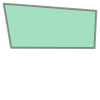

In [349]:
bord = outer_borders.geometry[0]
bord

In [620]:
geodf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326"
)

In [621]:
geoekat = geodf[geodf.within(bord) & (geodf.dissolution_date.isnull())]

In [622]:
geoekat.workers_count.sum() + geoekat.predicted_workers_count.sum()

np.float64(721407.5053096574)

In [645]:
geoekat.combined_workers_count.min()

np.float64(0.0)

In [624]:
geodadata = gpd.gpd.read_file('../ekb_info_dadata_geojson_v2.geojson')
geodadata = geodadata[geodadata.within(bord)]

In [625]:
geodadata_inns = geodadata.inn.values
not_found = []
def calc_new_coords(row):
    if row.geocoding_quality == 'house':
        return row.lon, row.lat
    else:
        if str(row.inn) in geodadata_inns:
            tmp = geodadata[geodadata.inn == str(row.inn)]
            return tmp.lon.values[0], tmp.lat.values[0]
        else:
            not_found.append(row.inn)

In [626]:
%%time
geoekat[['dadata_lon', 'dadata_lat']] = geoekat.apply(calc_new_coords, axis=1).apply(pd.Series)

CPU times: user 4min 49s, sys: 160 ms, total: 4min 49s
Wall time: 4min 49s


/usr/local/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [627]:
geoekat_dadata_geomatry = gpd.GeoDataFrame(
    geoekat, geometry=gpd.points_from_xy(geoekat.dadata_lon, geoekat.dadata_lat), crs="EPSG:4326"
)

In [628]:
ekat_simplified = geoekat_dadata_geomatry[['inn', 'dadata_lon', 'dadata_lat', 'workers_count', 'predicted_workers_count', 'combined_workers_count', 'line_2110', 'geometry']]


In [629]:
type(ekat_simplified)

geopandas.geodataframe.GeoDataFrame

In [646]:
ekat_simplified.combined_workers_count.min()

np.float64(0.0)

In [427]:
ekat_simplified.to_csv('ekat_workers_count_dadata_coords_predicted.csv')

In [647]:
geoekat_simplified = ekat_simplified

In [239]:
#no qgis

In [7]:
distr = gpd.read_file('ekat_districts_optimized_espg.geojson').to_crs(epsg=4326)

In [8]:
distr

fid     NO  CODE                         NAME  TYPENO             МУНИЦ  \
0      1   9901  None                       Кордон       9            Кордон   
1      2   9902  None                       Кордон       9            Кордон   
2      3   9903  None                       Кордон       9            Кордон   
3      4   9904  None                       Кордон       9            Кордон   
4      5   9905  None                       Кордон       9            Кордон   
..   ...    ...   ...                          ...     ...               ...   
726  727  10709  None  ГО Верхняя Пышма (пригород)       2  ГО Верхняя Пышма   
727  728  10710  None  ГО Верхняя Пышма (пригород)       2  ГО Верхняя Пышма   
728  729  10711  None  ГО Верхняя Пышма (пригород)       2  ГО Верхняя Пышма   
729  730  10712  None  ГО Верхняя Пышма (пригород)       2  ГО Верхняя Пышма   
730  731  10713  None  ГО Верхняя Пышма (пригород)       2  ГО Верхняя Пышма   

    simetra_workers_count                                           geometry  
0                    None  MULTIPOLYGON (((60.70904 57.30699, 60.70905 57...  
1                    None  MULTIPOLYGON (((61.11574 57.18993, 61.11575 57...  
2                    None  MULTIPOLYGON (((61.71909 57.10295, 61.7191 57....  
3                    None  MULTIPOLYGON (((61.64411 56.90578, 61.64411 56...  
4                    None  MULTIPOLYGON (((61.60135 56.7803, 61.60136 56....  
..                    ...                                                ...  
726                  None  MULTIPOLYGON (((60.64428 56.97249, 60.63567 56...  
727                  None  MULTIPOLYGON (((60.69266 57.00358, 60.70247 57...  
728                  None  MULTIPOLYGON (((60.69428 56.99472, 60.69447 56...  
729                  None  MULTIPOLYGON (((60.67122 56.95995, 60.67128 56...  
730                  None  MULTIPOLYGON (((60.62452 56.96835, 60.6239 56....  

[731 rows x 8 columns]

In [653]:
districts_df = distr.set_index('NO').to_crs('EPSG:3857')


In [654]:
companies_df = geoekat_simplified.to_crs('EPSG:3857')

In [648]:
min(geoekat_simplified.combined_workers_count)

0.0

In [255]:
import contextily as cx


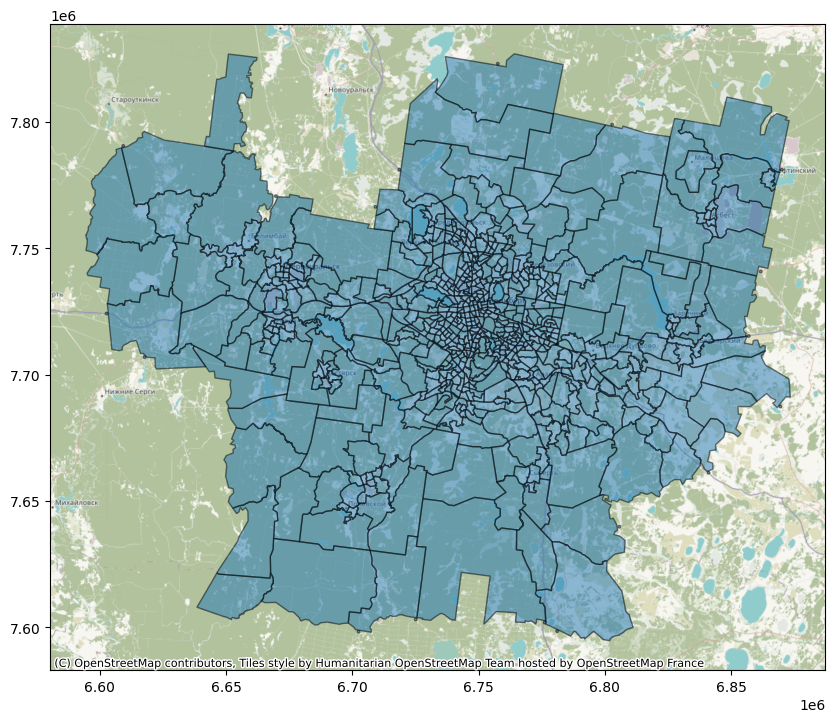

In [475]:
ax = districts_df.plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
cx.add_basemap(ax)

In [476]:
from shapely.geometry import Point


In [477]:
## aggregation

In [655]:
joined = gpd.sjoin(companies_df, districts_df, predicate='within', how='left')

In [656]:
districts_df['workers_count'] = joined.groupby('NO')['workers_count'].sum()
districts_df['workers_count'] = districts_df['workers_count'].fillna(0)
districts_df['combined_workers_count'] = joined.groupby('NO')['combined_workers_count'].sum()
districts_df['combined_workers_count'] = districts_df['combined_workers_count'].fillna(0)

In [677]:
districts_df.combined_workers_count.sum(), districts_df.workers_count.sum()

(np.float64(698405.1115268259), np.float64(511907.0))

In [1]:
districts_df.simetra_workers_count.sum()

NameError: name 'districts_df' is not defined

In [3]:
511907.0/1214959

0.4213368516962301

In [671]:
districts_df.simetra_workers_count.max()

np.int32(47577)

In [672]:
quantile_edges = districts_df['simetra_workers_count'].quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0])

In [673]:
bins = sorted(list(set(quantile_edges.values)))

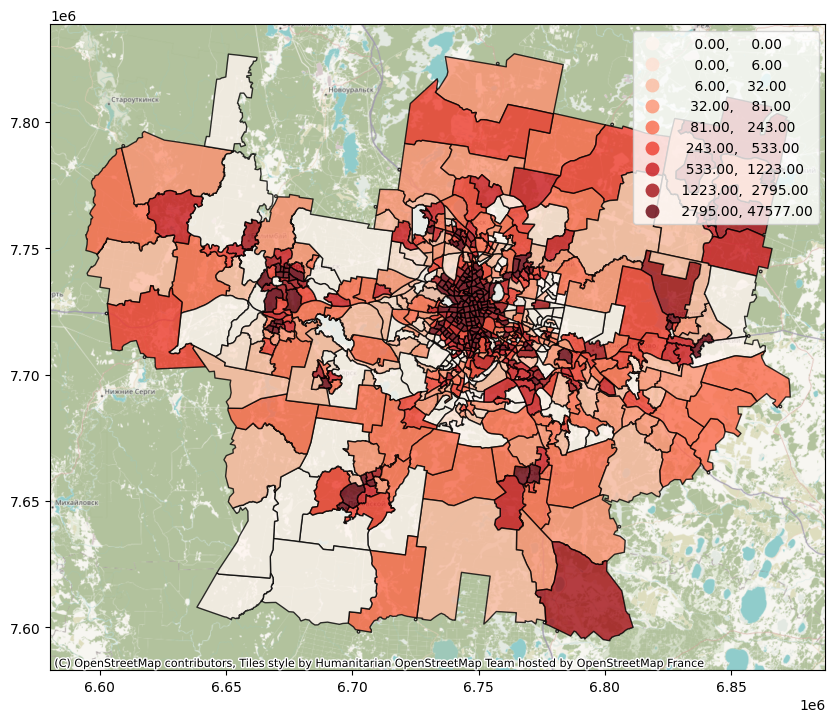

In [674]:
ax = districts_df.plot(figsize=(10, 10), alpha=0.8, edgecolor="k", column="simetra_workers_count", 
                       scheme='user_defined',      # пользовательские интервалы
                       classification_kwds={'bins': bins},
                       cmap='Reds', legend=True)
cx.add_basemap(ax)

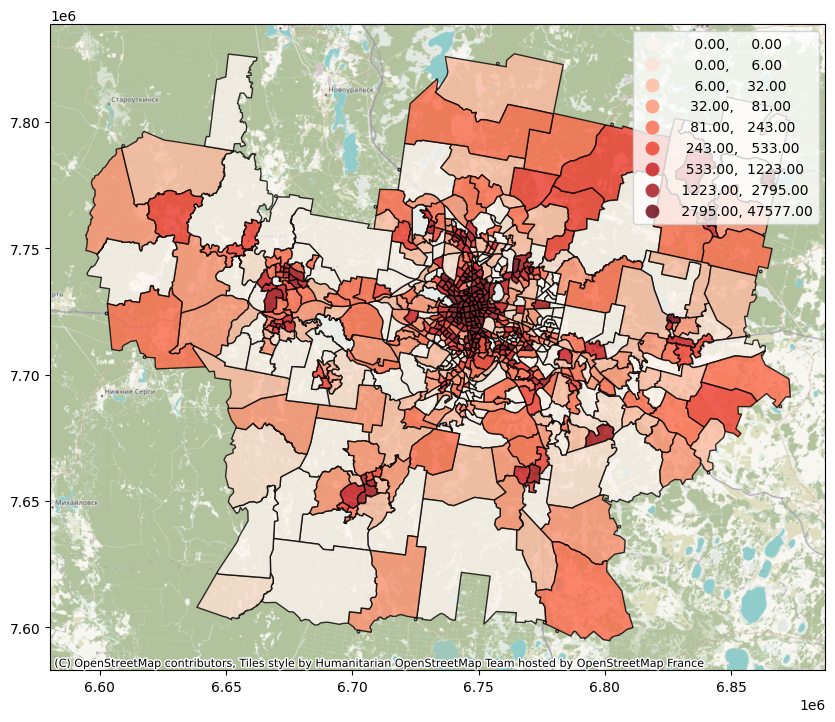

In [675]:
ax = districts_df.plot(figsize=(10, 10), alpha=0.8, edgecolor="k", column="combined_workers_count", 
                       scheme='user_defined',      # пользовательские интервалы
                       classification_kwds={'bins': bins},
                       cmap='Reds', legend=True)
cx.add_basemap(ax)

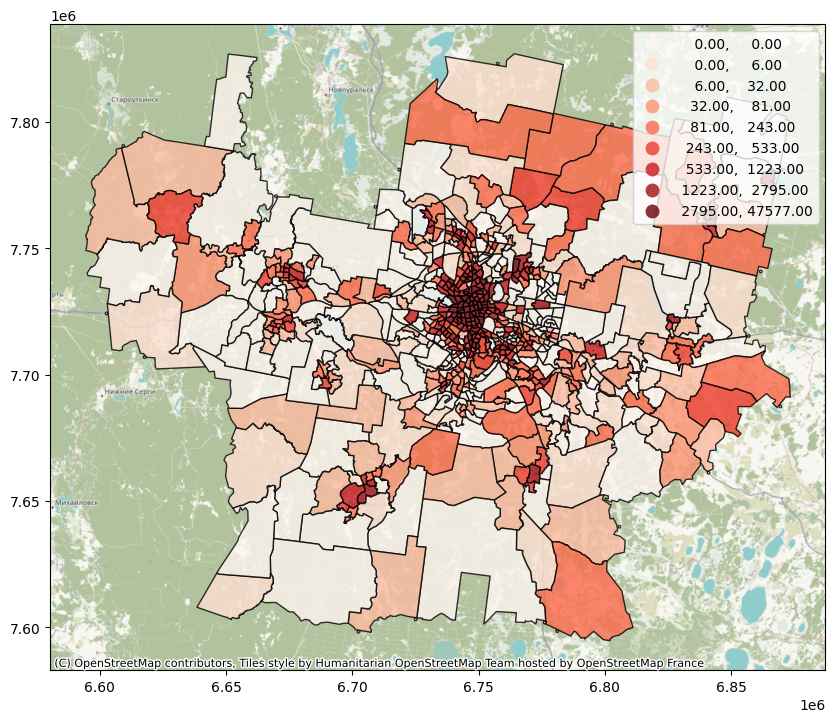

In [676]:
ax = districts_df.plot(figsize=(10, 10), alpha=0.8, edgecolor="k", column="workers_count", 
                       scheme='user_defined',      # пользовательские интервалы
                       classification_kwds={'bins': bins},
                       cmap='Reds', legend=True)
cx.add_basemap(ax)

In [695]:
districts_df.simetra_workers_count.corr(districts_df.workers_count)

np.float64(0.8293290021558347)

In [696]:
districts_df.simetra_workers_count.corr(districts_df.combined_workers_count)

np.float64(0.8428974582578711)

In [519]:
mre = ((districts_df.simetra_workers_count - districts_df.workers_count)/districts_df.simetra_workers_count)

In [539]:
import numpy as np

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [699]:
rmse(districts_df.simetra_workers_count, districts_df.workers_count)

np.float64(2339.366454625852)

In [700]:
rmse(districts_df.simetra_workers_count, districts_df.combined_workers_count)

np.float64(2013.989783998544)

In [682]:
districts_df['base_mre'] = (np.abs(districts_df.simetra_workers_count - districts_df.workers_count)/districts_df.simetra_workers_count)
districts_df['combined_mre'] = (np.abs(districts_df.simetra_workers_count - districts_df.combined_workers_count)/districts_df.simetra_workers_count)
districts_df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [683]:
districts_df['base_mre'].describe()

count    604.000000
mean       0.846035
std        0.820461
min        0.002528
25%        0.592705
50%        0.820078
75%        0.976248
max       10.790323
Name: base_mre, dtype: float64

In [684]:
districts_df['combined_mre'].describe()

count    604.000000
mean       1.044835
std        2.112655
min        0.000183
25%        0.449733
50%        0.690753
75%        0.936269
max       25.283123
Name: combined_mre, dtype: float64

In [571]:
import matplotlib.pyplot as plt

def plot_arr(arr, ax=None):
    ys = arr
    xs = [x for x in range(len(ys))]

    if ax:
        ax = plt.plot(xs, ys)
        return
    plt.plot(xs, ys)
    plt.show()
    # Make sure to close the plt object once done
    plt.close()

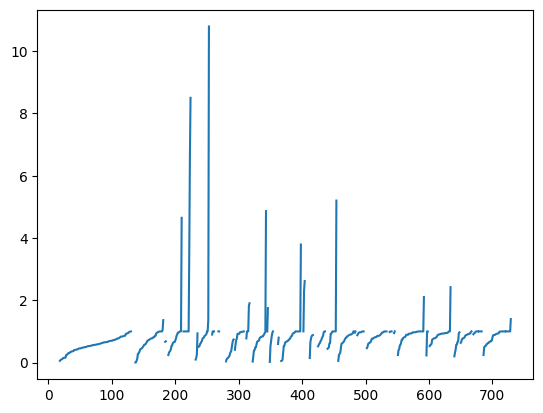

In [537]:
plot_arr(sorted(districts_df['base_mre'].values))

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.0553306342780027,
 0.08041874851296693,
 0.09551182843245633,
 0.10513908533710514,
 0.11549609810479376,
 0.14543354655294954,
 0.14745683621091926,
 0.153300841825432,
 0.15653698447153114,
 0.16098348887293612,
 0.24588631264023933,
 0.24865096884964435,
 0.2675140112089672,
 0.29753887596424633,
 0.3036184210526316,
 0.3045933734939759,
 0.33442569228248403,
 0.3359639233370913,
 0.3532543190036159,
 0.35690188360978353,
 0.3595755182625864,
 0.36477303615112805,
 0.3956013102480112,
 0.3963963963963964,
 0.4049994856496245,
 0.41260462826193994,
 0.4132306298142275,
 0.4213381555153707,
 0.42299898682877407,
 0.44017379679144386,
 0.45121951219512196,
 0.4520144120537177,
 0.4534511461134588,
 0.4569727047146402,
 0.4719436161561399,
 0.47232375979112273,
 0.47613254829448687,
 0.4870051008015545,
 0.48758620689655174,
 0.49444444444444446,
 0.4978161397670549,
 0.4985507

In [549]:
districts_df.to_csv('ekat_res.csv')

In [8]:
import pandas
districts_df = pandas.read_csv('ekat_res.csv')

In [560]:
districts_df['base_mre'].median()

np.float64(0.8200775891775325)

In [561]:
districts_df['combined_mre'].median()

np.float64(0.6988227244250306)

AttributeError: PatchCollection.set() got an unexpected keyword argument 'x'

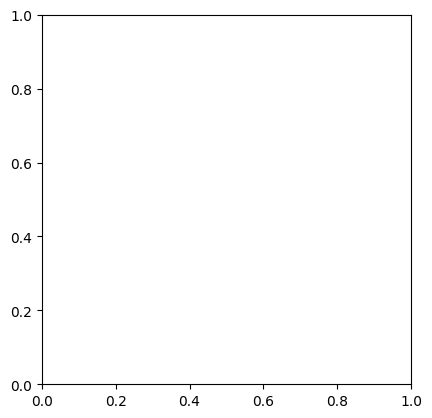

In [557]:
districts_df.plot(x='simetra_workers_count', y='combined_workers_count', style='o')

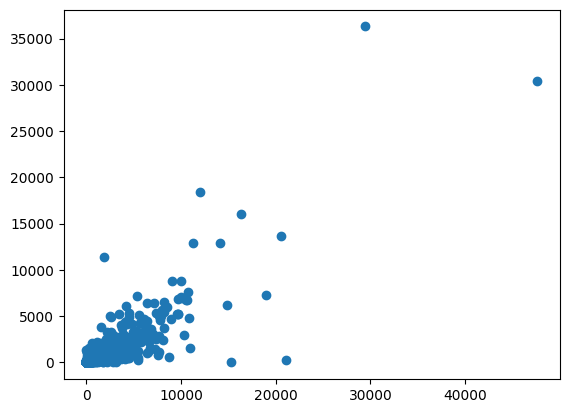

In [558]:
import matplotlib.pyplot as plt
plt.scatter(districts_df['simetra_workers_count'], districts_df['combined_workers_count'])

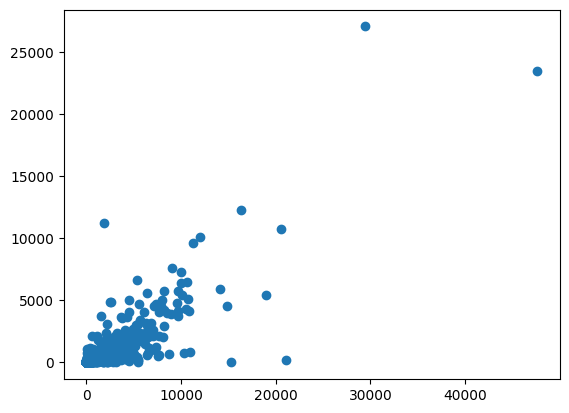

In [559]:
plt.scatter(districts_df['simetra_workers_count'], districts_df['workers_count'])

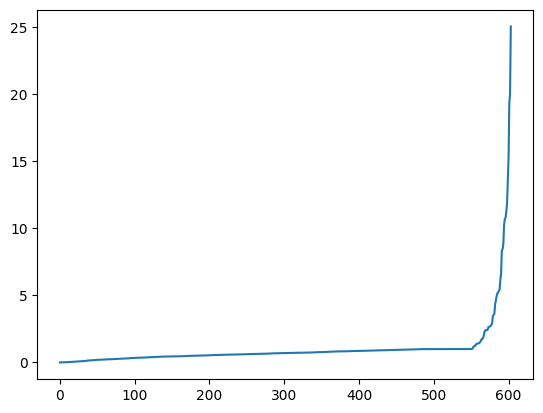

In [565]:
plot_arr()

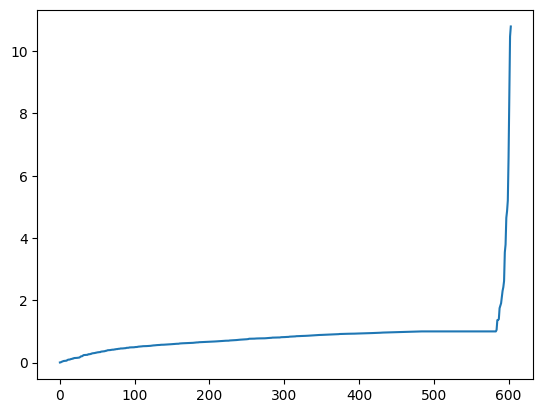

In [566]:
plot_arr()

In [567]:
fig = plt.figure()

<Figure size 640x480 with 0 Axes>

In [568]:
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

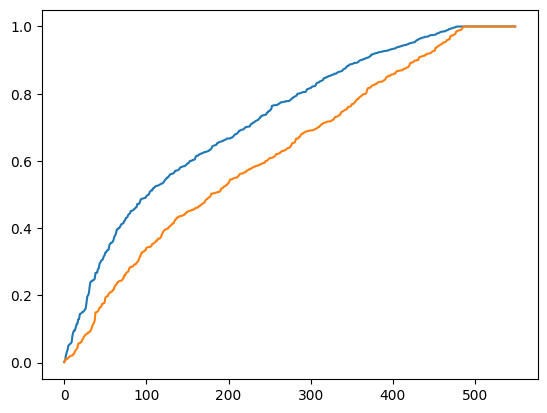

In [688]:
plot_arr(districts_df.sort_values('base_mre')['base_mre'][:550], ax1)
plot_arr(districts_df.sort_values('combined_mre')['combined_mre'][:550], ax2)

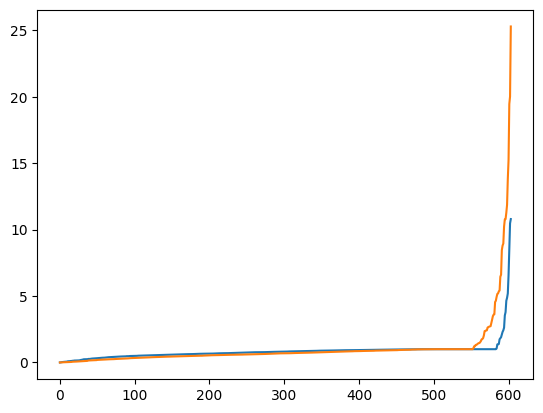

In [704]:
plot_arr(districts_df.sort_values('base_mre')['base_mre'], ax1)
plot_arr(districts_df.sort_values('combined_mre')['combined_mre'], ax2)

In [678]:
len(districts_df)

731

In [690]:
districts_df.base_mre.describe()

count    604.000000
mean       0.846035
std        0.820461
min        0.002528
25%        0.592705
50%        0.820078
75%        0.976248
max       10.790323
Name: base_mre, dtype: float64

In [691]:
districts_df.combined_mre.describe()

count    604.000000
mean       1.044835
std        2.112655
min        0.000183
25%        0.449733
50%        0.690753
75%        0.936269
max       25.283123
Name: combined_mre, dtype: float64

In [9]:
from sklearn.metrics import r2_score

only_good = districts_df

r2_base = r2_score(districts_df['simetra_workers_count'], districts_df['workers_count'])
r2_combined = r2_score(districts_df['simetra_workers_count'], districts_df['combined_workers_count'])

In [703]:
r2_score(districts_df['simetra_workers_count'], districts_df['workers_count']), r2_score(districts_df['simetra_workers_count'], districts_df['combined_workers_count'])


(0.540501650748433, 0.6594334687759282)

In [10]:
r2_base, r2_combined

(0.540501650748433, 0.65678409367662)

In [697]:
only_good.simetra_workers_count.corr(only_good.workers_count)

np.float64(0.843400089804301)

In [698]:
only_good.simetra_workers_count.corr(only_good.combined_workers_count)

np.float64(0.8489266680291244)

In [701]:
rmse(only_good.simetra_workers_count, only_good.workers_count)

np.float64(2664.1698771935426)

In [702]:
rmse(only_good.simetra_workers_count, only_good.combined_workers_count)

np.float64(2289.4065794527532)